In [1]:
!gdown 1I3hAt3wPZ2O7SOcWyvrOH76QCO-RM_70

Downloading...
From: https://drive.google.com/uc?id=1I3hAt3wPZ2O7SOcWyvrOH76QCO-RM_70
To: /kaggle/working/student_depression_dataset.csv
100%|███████████████████████████████████████| 2.90M/2.90M [00:00<00:00, 176MB/s]


> # Step 1: Import Libraries

In [3]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.svm import SVC
from cvxopt import matrix, solvers

import joblib
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import plotly.express as px
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
%matplotlib inline

> # Step 2: Load the Dataset

In [4]:
data = pd.read_csv("/kaggle/working/student_depression_dataset.csv")
data

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,'5-6 hours',Unhealthy,'Class 12',Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,'Less than 5 hours',Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,'5-6 hours',Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,'Less than 5 hours',Healthy,'Class 12',Yes,10.0,5.0,No,1


In [ ]:
data.info()

# Step 3: Data Cleaning & Preprocessing

> ## 3.1 Convert and Clean Data Types

In [5]:
# Convert columns that should be categorical
cat_cols = ['Gender', 'City', 'Profession', 'Dietary Habits', 'Degree',
            'Have you ever had suicidal thoughts ?', 'Financial Stress',
            'Family History of Mental Illness']
for col in cat_cols:
    data[col] = data[col].astype('category')

In [6]:
# Create a mapping for Sleep Duration values to numerical categories
sleep_duration_mapping = {
    "'Less than 5 hours'": 1,
    "'5-6 hours'": 2,
    "'7-8 hours'": 3,
    "'More than 8 hours'": 4,
    'Others': 5
}

# Apply the mapping to the 'Sleep Duration' column
data['Sleep Duration'] = data['Sleep Duration'].map(sleep_duration_mapping)

# Display the updated 'Sleep Duration' column
print(data['Sleep Duration'].value_counts())

data['Sleep Duration'] = data['Sleep Duration'].astype('category')

Sleep Duration
1    8310
3    7346
2    6183
4    6044
5      18
Name: count, dtype: int64


In [ ]:
data.info()

> ## 3.2 Check for Missing Values, Duplicate Row and Outlier

In [ ]:
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

In [ ]:
dup_rows = data[data.drop(columns=['id','Depression']).duplicated(keep=False)]
display(dup_rows)

In [ ]:
num_features = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 
                'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=data[feature], color=(114/255, 182/255, 161/255, 1))
    plt.title(f'Boxplot of {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

In [7]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

outliers_summary = {}
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask_out = (data[col] < lower_bound) | (data[col] > upper_bound)
    outliers_idx = data.index[mask_out].tolist()

    outliers_summary[col] = {
        'count': len(outliers_idx),
        'indices': outliers_idx,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
    print(f"– {col}: {len(outliers_idx)} outliers (n < {lower_bound:.2f} or n > {upper_bound:.2f})")

total_outliers = sum(v['count'] for v in outliers_summary.values())
print(f"\nTotal of {total_outliers} outliers detected across {len(numeric_cols)} numeric columns.")

all_outlier_idxs = set(idx for info in outliers_summary.values() for idx in info['indices'])
data = data.drop(index=all_outlier_idxs).reset_index(drop=True)
print(f"Dropped {len(all_outlier_idxs)} rows with outliers. New shape: {data.shape}")

– id: 0 outliers (n < -71129.50 or n > 211986.50)
– Age: 12 outliers (n < 7.50 or n > 43.50)
– Academic Pressure: 0 outliers (n < -1.00 or n > 7.00)
– Work Pressure: 3 outliers (n < 0.00 or n > 0.00)
– CGPA: 9 outliers (n < 2.35 or n > 12.87)
– Study Satisfaction: 0 outliers (n < -1.00 or n > 7.00)
– Job Satisfaction: 8 outliers (n < 0.00 or n > 0.00)
– Work/Study Hours: 0 outliers (n < -5.00 or n > 19.00)
– Depression: 0 outliers (n < -1.50 or n > 2.50)

Total of 32 outliers detected across 9 numeric columns.
Dropped 23 rows with outliers. New shape: (27878, 18)


In [ ]:
num_features = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 
                'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=data[feature], color=(114/255, 182/255, 161/255, 1))
    plt.title(f'Boxplot of {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

In [ ]:
def v_counts(df):
    for col in df.columns:
        if pd.api.types.is_categorical_dtype(df[col]):
            cnt = df[col].value_counts(dropna=False)
            pct = df[col].value_counts(normalize=True, dropna=False).mul(100).round(3)

            summary = pd.concat([cnt, pct], axis=1)
            summary.columns = ['Count', 'Percent (%)']

            title = f" Column: {col} "
            print(title.center(50, '='))

            display(summary)

v_counts(data)

In [8]:
data = data[data['Sleep Duration'] != 5]

data['Sleep Duration'] = data['Sleep Duration'].cat.remove_unused_categories()

print(data['Sleep Duration'].value_counts(dropna=False))

Sleep Duration
1    8302
3    7339
2    6178
4    6041
Name: count, dtype: int64


In [9]:
data = data[data['Financial Stress'] != '?']

data['Financial Stress'] = data['Financial Stress'].cat.remove_unused_categories()

print(data['Financial Stress'].value_counts(dropna=False))

Financial Stress
5.0    6705
4.0    5767
3.0    5216
1.0    5114
2.0    5055
Name: count, dtype: int64


In [10]:
data = data[data['Dietary Habits'] != 'Others']

data['Dietary Habits'] = data['Dietary Habits'].cat.remove_unused_categories()

print(data['Dietary Habits'].value_counts(dropna=False))

Dietary Habits
Unhealthy    10298
Moderate      9906
Healthy       7641
Name: count, dtype: int64


# Step 4: Exploratory Data Analysis (EDA)

> ## 4.1 Overall Distribution of the Target Variable

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Depression', data=data, palette="Set2")
plt.title("Distribution of Depression among Students")
plt.xlabel("Depression (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

print(data['Depression'].value_counts(dropna=False))

> ## 4.2 Analyzing Categorical Variables

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Gender', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Depression")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Profession', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by Profession")
plt.xlabel("Profession")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(title="Depression")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Sleep Duration', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by Sleep Duration")
plt.xlabel("Sleep Duration")
plt.ylabel("Count")
plt.legend(title="Depression")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Dietary Habits', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by Dietary Habits")
plt.xlabel("Dietary Habits")
plt.ylabel("Count")
plt.legend(title="Depression")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Degree', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by Degree")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(title="Depression")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Have you ever had suicidal thoughts ?', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by 'Have you ever had suicidal thoughts ?'")
plt.xlabel("Have you ever had suicidal thoughts ?")
plt.ylabel("Count")
plt.legend(title="Depression")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Family History of Mental Illness', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by Family History of Mental Illness")
plt.xlabel("Family History of Mental Illness")
plt.ylabel("Count")
plt.legend(title="Depression")
plt.show()

> ## 4.3 Distribution of Numerical Features

In [ ]:
num_features = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
                'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours']
data[num_features].hist(bins=20, figsize=(15,10), color=(114/255, 182/255, 161/255, 1))
plt.tight_layout()
plt.show()

> ## 4.4 Correlation Analysis

In [11]:
print("Checking values in Work Pressure:")
print(data['Work Pressure'].value_counts())

print("\nChecking values in Job Satisfaction:")
print(data['Job Satisfaction'].value_counts())

Checking values in Work Pressure:
Work Pressure
0.0    27845
Name: count, dtype: int64

Checking values in Job Satisfaction:
Job Satisfaction
0.0    27845
Name: count, dtype: int64


In [12]:
data = data.drop(columns=['Work Pressure', 'Job Satisfaction'])

data.shape

(27845, 16)

In [ ]:
plt.figure(figsize=(10,8))
num_cols = ['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Work/Study Hours']
corr_matrix = data[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Step 5: Feature Engineering

> ## 5.1 Feature Selection

In [13]:
data = data.drop(columns=['Profession', 'City'])

data.shape

(27845, 14)

> ## 5.2 Encoding Categorical Variables

In [14]:
cat_features = ['Gender', 'Sleep Duration', 'Dietary Habits', 'Degree',
                'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Financial Stress']

data_encoded = pd.get_dummies(data, columns=cat_features, drop_first=True)

data_encoded

,id,Age,Academic Pressure,CGPA,Study Satisfaction,Work/Study Hours,Depression,Gender_Male,Sleep Duration_2,Sleep Duration_3,...,Degree_MHM,Degree_MSc,Degree_Others,Degree_PhD,Have you ever had suicidal thoughts ?_Yes,Family History of Mental Illness_Yes,Financial Stress_2.0,Financial Stress_3.0,Financial Stress_4.0,Financial Stress_5.0
0,2,33.0,5.0,8.97,2.0,3.0,1,True,True,False,...,False,False,False,False,True,False,False,False,False,False
1,8,24.0,2.0,5.90,5.0,3.0,0,False,True,False,...,False,False,False,False,False,True,True,False,False,False
2,26,31.0,3.0,7.03,5.0,9.0,0,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,30,28.0,3.0,5.59,2.0,4.0,1,False,False,True,...,False,False,False,False,True,True,False,False,False,True
4,32,25.0,4.0,8.13,3.0,1.0,0,False,True,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27873,140685,27.0,5.0,5.75,5.0,7.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,False
27874,140686,27.0,2.0,9.40,3.0,0.0,0,True,False,False,...,False,True,False,False,False,True,False,True,False,False
27875,140689,31.0,3.0,6.61,4.0,12.0,0,True,True,False,...,False,False,False,False,False,False,True,False,False,False
27876,140690,18.0,5.0,6.88,2.0,10.0,1,False,False,False,...,False,False,False,False,True,False,False,False,False,True


# Step 6: Machine Learning Model Building

In [15]:
drop_cols = ['id', 'Depression']
data_clean = data_encoded.drop(columns=drop_cols)

In [16]:
data_clean.shape

(27845, 44)

In [21]:
X = data_clean
y = data['Depression']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

> ## 6.1 Logistic Regression Model


> ### with sklearn

Logistic Regression Sklearn Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      2268
           1       0.87      0.88      0.87      3301

    accuracy                           0.85      5569
   macro avg       0.85      0.84      0.84      5569
weighted avg       0.85      0.85      0.85      5569



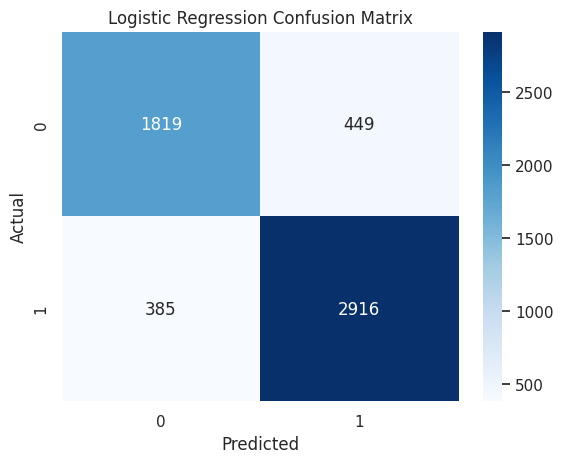

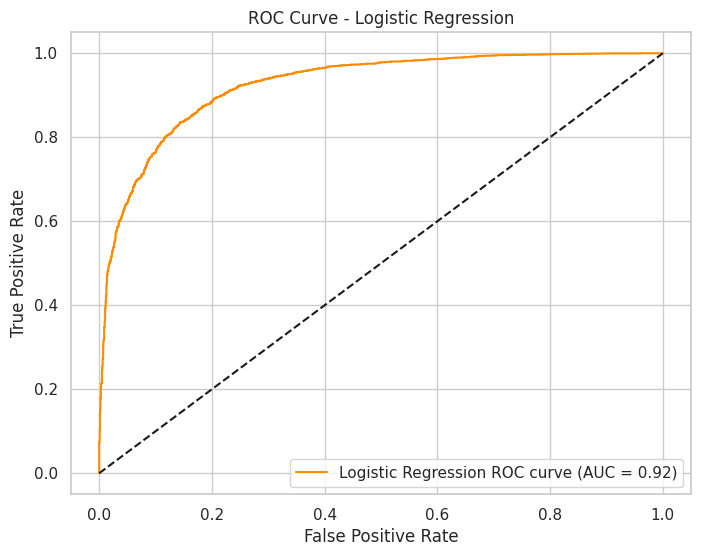

In [19]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

joblib.dump(log_model, 'logreg_sklearn.pkl')

y_pred_log = log_model.predict(X_test)
print("Logistic Regression Sklearn Classification Report:")
print(classification_report(y_test, y_pred_log))

cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt="d", cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_prob_log = log_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Logistic Regression ROC curve (AUC = {roc_auc_log:.2f})', color='darkorange')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

> ### with scratch implementation

Logistic Regression Scratch Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      2268
           1       0.87      0.88      0.88      3301

    accuracy                           0.85      5569
   macro avg       0.85      0.84      0.85      5569
weighted avg       0.85      0.85      0.85      5569



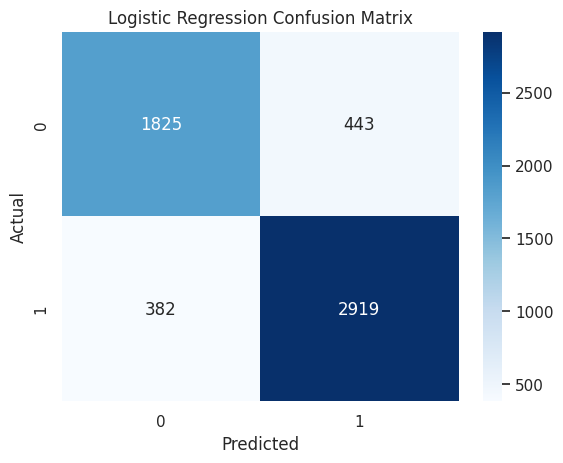

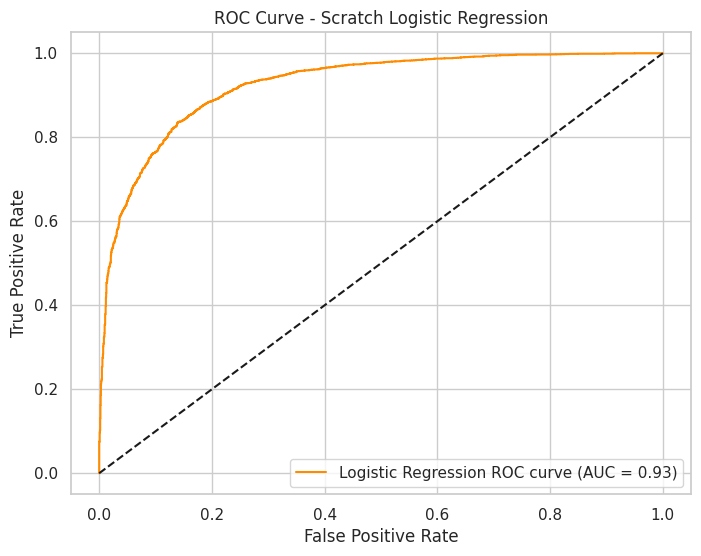

In [35]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = sigmoid(linear_model)
        return np.where(y_pred > 0.5, 1, 0)

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        probs = sigmoid(linear_model)
        return np.vstack([1 - probs, probs]).T

model = LogisticRegressionScratch(learning_rate=0.01, n_iters=5000)
model.fit(X_train, y_train)

model_state = {
    'learning_rate': model.lr,
    'n_iters': model.n_iters,
    'weights': model.weights,
    'bias': model.bias
}
joblib.dump(model_state, 'logreg_scratch.pkl')

# Định nghĩa hàm dự đoán không cần lớp ban đầu
def predict_with_checkpoint(X, checkpoint_path):
    # Tải trạng thái mô hình
    state = joblib.load(checkpoint_path)
    weights = state['weights']
    bias = state['bias']
    
    # Dự đoán
    linear_model = np.dot(X, weights) + bias
    y_pred = sigmoid(linear_model)
    return np.where(y_pred > 0.5, 1, 0)

def predict_proba_with_checkpoint(X, checkpoint_path):
    # Tải trạng thái mô hình
    state = joblib.load(checkpoint_path)
    weights = state['weights']
    bias = state['bias']
    
    # Dự đoán xác suất
    linear_model = np.dot(X, weights) + bias
    probs = sigmoid(linear_model)
    return np.vstack([1 - probs, probs]).T

y_pred = predict_with_checkpoint(X_test, 'logreg_scratch.pkl')
print("Logistic Regression Scratch Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_prob = predict_proba_with_checkpoint(X_test, 'logreg_scratch.pkl')[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Scratch Logistic Regression')
plt.legend(loc='lower right')
plt.show()

> ## 6.2 KNN Model

> ### with sklearn

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=18)
knn_model.fit(X_train, y_train)

joblib.dump(knn_model, 'knn_sklearn.pkl')

y_pred_knn = knn_model.predict(X_test)
print("KNN Sklearn Classification Report:")
print(classification_report(y_test, y_pred_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt="d", cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_prob_knn = knn_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'KNN ROC curve (AUC = {roc_auc_knn:.2f})', color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend(loc="lower right")
plt.show()

> ### with scratch implementation

KNN Scratch Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77      2268
           1       0.82      0.90      0.86      3301

    accuracy                           0.82      5569
   macro avg       0.82      0.81      0.81      5569
weighted avg       0.82      0.82      0.82      5569



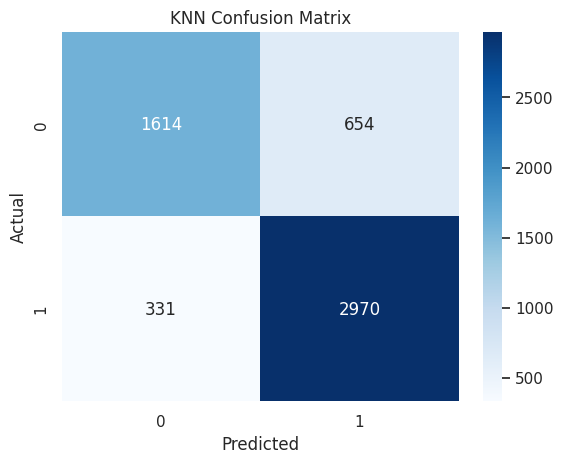

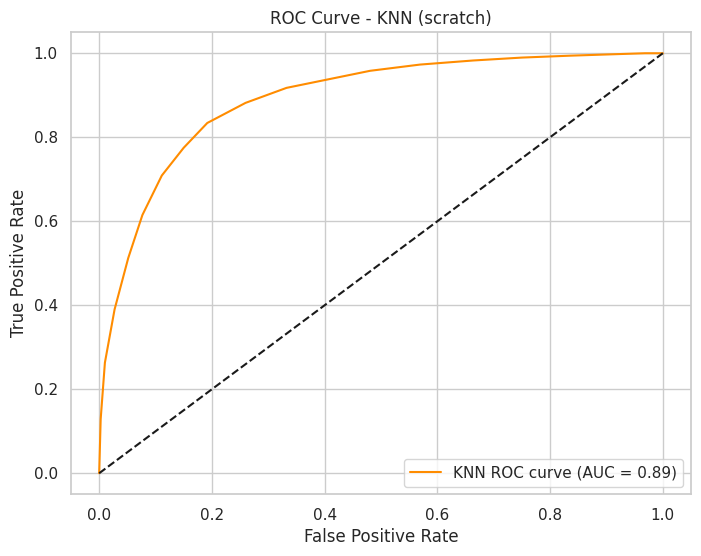

In [36]:
# Hàm tính khoảng cách Euclidean (sẽ cần khi dự đoán)
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Định nghĩa lớp KNN (dùng để huấn luyện)
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X.values if hasattr(X, 'values') else np.array(X)
        self.y_train = y.values if hasattr(y, 'values') else np.array(y)

    def _predict_one(self, x):
        distances = np.linalg.norm(self.X_train - x, axis=1)
        k_idx = np.argsort(distances)[:self.k]
        labels = self.y_train[k_idx]
        return Counter(labels).most_common(1)[0][0]

    def predict(self, X):
        X_arr = X.values if hasattr(X, 'values') else np.array(X)
        return np.array([self._predict_one(x) for x in X_arr])

    def predict_proba(self, X):
        X_arr = X.values if hasattr(X, 'values') else np.array(X)
        probs = []
        for x in X_arr:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_idx = np.argsort(distances)[:self.k]
            labels = self.y_train[k_idx]
            probs.append(np.mean(labels == 1))
        probs = np.array(probs)
        return np.vstack([1 - probs, probs]).T

# Huấn luyện mô hình
clf = KNN(k=18)
clf.fit(X_train, y_train)

# Lưu trạng thái mô hình (X_train, y_train, k) thay vì toàn bộ đối tượng
model_state = {
    'k': clf.k,
    'X_train': clf.X_train,
    'y_train': clf.y_train
}
joblib.dump(model_state, 'knn_scratch.pkl')

# Hàm dự đoán không cần lớp KNN
def predict_with_checkpoint(X, checkpoint_path):
    # Tải trạng thái mô hình
    state = joblib.load(checkpoint_path)
    k = state['k']
    X_train = state['X_train']
    y_train = state['y_train']
    
    # Chuyển X thành numpy array nếu cần
    X_arr = X.values if hasattr(X, 'values') else np.array(X)
    
    # Dự đoán
    predictions = []
    for x in X_arr:
        distances = np.linalg.norm(X_train - x, axis=1)
        k_idx = np.argsort(distances)[:k]
        labels = y_train[k_idx]
        most_common = Counter(labels).most_common(1)[0][0]
        predictions.append(most_common)
    return np.array(predictions)

# Hàm dự đoán xác suất không cần lớp KNN
def predict_proba_with_checkpoint(X, checkpoint_path):
    # Tải trạng thái mô hình
    state = joblib.load(checkpoint_path)
    k = state['k']
    X_train = state['X_train']
    y_train = state['y_train']
    
    # Chuyển X thành numpy array nếu cần
    X_arr = X.values if hasattr(X, 'values') else np.array(X)
    
    # Dự đoán xác suất
    probs = []
    for x in X_arr:
        distances = np.linalg.norm(X_train - x, axis=1)
        k_idx = np.argsort(distances)[:k]
        labels = y_train[k_idx]
        probs.append(np.mean(labels == 1))
    probs = np.array(probs)
    return np.vstack([1 - probs, probs]).T

# Dự đoán trên X_test bằng hàm mới (giả lập tải lại mà không cần lớp)
y_pred = predict_with_checkpoint(X_test, 'knn_scratch.pkl')
print("KNN Scratch Classification Report:")
print(classification_report(y_test, y_pred))

# Vẽ confusion matrix
cm_knn = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_knn, annot=True, fmt="d", cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Tính và vẽ ROC Curve
y_prob_knn = predict_proba_with_checkpoint(X_test, 'knn_scratch.pkl')[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'KNN ROC curve (AUC = {roc_auc_knn:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN (scratch)')
plt.legend(loc="lower right")
plt.show()

> ## 6.3 Random Forest Model

> ### with sklearn

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=27, random_state=42)
rf_model.fit(X_train, y_train)

joblib.dump(rf_model, 'rf_sklearn.pkl')

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Sklearn Classification Report:")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_prob_rf = rf_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.2f})', color='darkorange')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

> ### with scratch implementation

In [ ]:
# Hàm hỗ trợ
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]

def most_common_label(y):
    counter = Counter(y)
    return counter.most_common(1)[0][0]

# Hàm tuần tự hóa cây (convert Node thành dict)
def serialize_tree(node):
    if node is None:
        return None
    return {
        'feature': node.feature,
        'threshold': node.threshold,
        'left': serialize_tree(node.left),
        'right': serialize_tree(node.right),
        'value': node.value
    }

# Hàm dự đoán không cần lớp
def predict_with_tree(x, tree):
    if tree['value'] is not None:
        return tree['value']
    if x[tree['feature']] <= tree['threshold']:
        return predict_with_tree(x, tree['left'])
    return predict_with_tree(x, tree['right'])

def predict_with_forest(X, forest_state):
    tree_preds = []
    for tree_dict in forest_state['trees']:
        preds = [predict_with_tree(x, tree_dict) for x in X]
        tree_preds.append(preds)
    tree_preds = np.array(tree_preds)
    tree_preds = np.swapaxes(tree_preds, 0, 1)
    y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
    return np.array(y_pred)

# Định nghĩa lớp DecisionTree và RandomForest (dùng để huấn luyện)
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = entropy(y)
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r
        return parent_entropy - child_entropy

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _most_common_label(self, y):
        return most_common_label(y)

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        y = y.to_numpy()
        self.trees = []
        for _ in tqdm(range(self.n_trees)):
            tree = DecisionTree(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                n_feats=self.n_feats,
            )
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

# Huấn luyện mô hình
clf = RandomForest(n_trees=100, max_depth=27)
clf.fit(X_train, y_train)

# Lưu trạng thái mô hình (chuyển cây thành dict)
forest_state = {
    'n_trees': clf.n_trees,
    'min_samples_split': clf.min_samples_split,
    'max_depth': clf.max_depth,
    'n_feats': clf.n_feats,
    'trees': [serialize_tree(tree.root) for tree in clf.trees]
}
joblib.dump(forest_state, 'rf_scratch.pkl')

# Dự đoán trên X_test bằng hàm mới
y_pred_rf = predict_with_forest(X_test, forest_state)

print("Random Forest Scratch Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Vẽ confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Lưu ý: RandomForest từ scratch không có predict_proba tích hợp, cần tự tính
# Dùng phương pháp đơn giản: lấy tỷ lệ dự đoán 1 từ các cây
def predict_proba_with_forest(X, forest_state):
    tree_probs = []
    for tree_dict in forest_state['trees']:
        preds = [predict_with_tree(x, tree_dict) for x in X]
        tree_probs.append(preds)
    tree_probs = np.array(tree_probs)
    tree_probs = np.swapaxes(tree_probs, 0, 1)
    y_probs = np.mean(tree_probs == 1, axis=1)
    return np.vstack([1 - y_probs, y_probs]).T

y_prob_rf = predict_proba_with_forest(X_test, forest_state)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

  2%|▏         | 2/100 [00:33<27:17, 16.71s/it]

> ## 6.4 SVM Model

> ### with sklearn

In [ ]:
svm_model = SVC(kernel='linear', C=10, probability=True, random_state=42)
svm_model.fit(X_train, y_train)

joblib.dump(svm_model, 'svm_sklearn.pkl')

y_pred = svm_model.predict(X_test)
print("SVM Sklearn Classification Report:")
print(classification_report(y_test, y_pred))

cm_svm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_svm, annot=True, fmt="d", cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_prob_svm = svm_model.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM ROC curve (AUC = {roc_auc_svm:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()

> ### with scratch implementation

In [ ]:
class SVMLinear:
    def __init__(self, C=1.0, threshold=1e-5):
        self.C = C
        self.threshold = threshold
        self.w = None
        self.b = None
        self.support_vectors = None
        self.support_labels = None
        self.support_lambdas = None

    def fit(self, X_train, y_train):
        # Convert labels to {-1, 1}
        y_train_svm = np.where(y_train == 0, -1, 1)
        N = X_train.shape[0]

        # Compute the kernel matrix K for linear kernel: K[i,j] = y_i * y_j * (x_i . x_j)
        K = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                K[i, j] = y_train_svm[i] * y_train_svm[j] * np.dot(X_train[i], X_train[j])
        K = matrix(K)

        # Define QP problem parameters
        p = matrix(-np.ones((N, 1)))  # Linear term: -1 for all lambdas
        # Soft-margin constraints: 0 <= lambda <= C
        G = matrix(np.vstack((-np.eye(N), np.eye(N))))
        h = matrix(np.hstack((np.zeros(N), np.ones(N) * self.C)))
        A = matrix(y_train_svm, (1, N), 'd')  # Equality constraint: y^T lambda = 0
        b = matrix(0.0)

        # Solve QP problem
        solvers.options['show_progress'] = False
        sol = solvers.qp(K, p, G, h, A, b)
        l = np.array(sol['x']).flatten()  # Lagrange multipliers

        # Identify support vectors (lambda > small threshold)
        support_indices = np.where(l > self.threshold)[0]
        self.support_vectors = X_train[support_indices]
        self.support_labels = y_train_svm[support_indices]
        self.support_lambdas = l[support_indices]

        # Compute weight vector w
        self.w = np.sum(self.support_lambdas[:, None] * self.support_labels[:, None] * self.support_vectors, axis=0)

        # Compute bias b using average over support vectors
        self.b = np.mean(self.support_labels - self.support_vectors.dot(self.w))

    def predict(self, X):
        # Predict using decision function
        return np.sign(X.dot(self.w) + self.b)

    def save_model(self, filename):
        model_dict = {
            'w': self.w,
            'b': self.b,
            'support_vectors': self.support_vectors,
            'support_labels': self.support_labels,
            'support_lambdas': self.support_lambdas,
            'C': self.C,
            'threshold': self.threshold
        }
        joblib.dump(model_dict, filename)

    def load_model(self, filename):
        model_dict = joblib.load(filename)
        self.w = model_dict['w']
        self.b = model_dict['b']
        self.support_vectors = model_dict['support_vectors']
        self.support_labels = model_dict['support_labels']
        self.support_lambdas = model_dict['support_lambdas']
        self.C = model_dict['C']
        self.threshold = model_dict['threshold']

svm = SVMLinear(C=10, threshold=1e-5)
svm.fit(X_train, y_train)
svm.save_model('svm_scratch.pkl')

y_pred_svm = svm.predict(X_test)
y_pred = np.where(y_pred_svm == 1, 1, 0)  # Convert back to {0, 1} for metrics

# Classification report
print("SVM Scratch Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm_svm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_svm, annot=True, fmt="d", cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Approximate probabilities for ROC curve using decision function
decision_values = X_test.dot(svm.w) + svm.b
y_prob_svm = 1 / (1 + np.exp(-decision_values))

# ROC curve
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM ROC curve (AUC = {roc_auc_svm:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()

In [28]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X.values if hasattr(X, 'values') else np.array(X)
        self.y_train = y.values if hasattr(y, 'values') else np.array(y)

    def _predict_one(self, x):
        distances = np.linalg.norm(self.X_train - x, axis=1)
        k_idx    = np.argsort(distances)[:self.k]
        labels   = self.y_train[k_idx]
        return Counter(labels).most_common(1)[0][0]

    def predict(self, X):
        X_arr = X.values if hasattr(X, 'values') else np.array(X)
        return np.array([self._predict_one(x) for x in X_arr])

    def predict_proba(self, X):
        X_arr = X.values if hasattr(X, 'values') else np.array(X)
        probs = []
        for x in X_arr:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_idx     = np.argsort(distances)[:self.k]
            labels    = self.y_train[k_idx]
            probs.append(np.mean(labels == 1))
        probs = np.array(probs)
        return np.vstack([1 - probs, probs]).T

In [32]:
import joblib
import numpy as np
from sklearn.metrics import accuracy_score
import os

model_files = [
    # 'knn_scratch.pkl',
    # 'knn_sklearn.pkl',
    # 'logreg_scratch.pkl',
    # 'logreg_sklearn.pkl',
    # 'rf_scratch.pkl',
    # 'rf_sklearn.pkl',
    'svm_scratch.pkl',
    'svm_sklearn.pkl'
]

# Thư mục chứa các tệp mô hình (thay bằng đường dẫn thực tế trên Kaggle)
model_dir = '/kaggle/input/models'  # Cập nhật đường dẫn đúng

# Duyệt qua từng tệp mô hình
for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    
    # Kiểm tra xem tệp có tồn tại không
    if os.path.exists(model_path):
        # Tải mô hình
        with open(model_path, 'rb') as file:
            model = joblib.load(file)
        
        # Dự đoán trên X_test
        y_pred = model.predict(X_test)
        
        # Tính accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Xuất kết quả
        print(f"Model: {model_file} - Accuracy: {accuracy:.4f}")
    else:
        print(f"Model file {model_file} not found at {model_path}")


AttributeError: 'dict' object has no attribute 'predict'